# Image segmentation demo

This notebook shows how to build and train a KuraNet instance for learning couplings which promote cluster synchrony corresponding to segments in a natural image. We will consider an equilibrium Kuramoto model of the form $$\dot{\theta_i} = \sum_j K_{ij}\sin(\theta_j(t) - \theta_i(t))$$
where $(K)_{ij} \in \mathcal{K}$ is an $n \times n$ coupling matrix. Each oscillator, $i$, is associated to an i.i.d. random feature $x_i\in \mathbb{R}^5 \subset \mathcal{X}$ which has a label $y_i = y(x_i) \in {1, \ldots, k}$. The feature, $x_i$, consists of the three RGB values at a given pixel together with its coordinates in the image. Absuing terminology, we consider these random features to be the "quenched disorder" of KuraNet since they affect the long-term learning dynamics, even if they don't influence the short-term evolution. 

We will use a deep neural network to approximate the function $\mathcal{X}^n \times \mathcal{X}^n \to \mathcal{K}$ that makes the oscillators synchronize into clusters respecting the labels, $y_i$. This deep neural network is trained to produe couplings which minimize the circular variance within each group and a potential measuring desynchrony between all groups. If target cluster $l$, has mean phase $\langle \theta \rangle_l(t)$, the desynchrony potential is $$S= \lim_{t\to \infty} \sum_g^k \frac{1}{2g^2k}\left| \sum_l^k e^{ig\langle \theta \rangle_l(t)}\right|^2.$$

First, we load some modules and set the CUDA device. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')
import torch
from torch.utils.data import DataLoader
from torch.utils.data.dataset import TensorDataset
import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from models import KuraNet
from train import optimize_connectivity_net
from data import make_data, get_BSDS_info
from utils import circular_variance, circular_moments, cohn_loss, make_masks
from skimage.io import imread
import cv2 as cv

# Set CUDA device
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

## Make data and set parameters

Next we generate and save the image data. By default, the following cell will download and unzip a tar.gz file into your home directory containing the BSDS image data. Set the keyword `download` to False to prevent this.  Images are denoted by a six-digit tag.

In [17]:
from os.path import expanduser
home = expanduser("~")
data_base_dir = os.path.join(home,'cluster_synchrony1')
if not os.path.exists(data_base_dir): os.makedirs(data_base_dir)
    
full_BSDS_path = os.path.join(home, 'BSDS/BSR/BSDS500/data/')
data_names=['BSDS']
dist_names = ['361010'] #90076, 118020, 124084, 189011, 229036, 247003, 296028, 317080, 361010

# Uncomment this line to generate data
make_data(data_names[0], dist_names[0], data_base_dir=data_base_dir, download=False)

# make_all_data(num_samples=args.num_samples,data_dir=args.data_dir)

True

In [18]:
seed=0
model_type='xy'
num_samples=10000
num_epochs=1
num_units=100
batch_size=100
feature_dim=5
num_hid_units=128
symmetric=False
normalize='none'
device='cuda'
adjoint=True
solver_method='euler'
optimizer='SGD'
max_grad_norm=1.0
lr=5e-3
momentum=0.0
loss_type='circular_moments'
alpha=15
gd_steps=100
burn_in_steps=50
measure_cx=False
set_gain=True
gain=.5
initial_phase='normal'

num_batches = int(num_samples/num_units)

 # Set loss function
if loss_type == 'circular_variance':
    loss_func = circular_variance
elif loss_type == 'circular_moments':
    loss_func = circular_moments
elif loss_type == 'cohn_loss':
    loss_func = cohn_loss
else:
    raise Exception('Loss type not recognized.')
    
train_dls  = {}
test_dls   = {}
train_dts    = {}
test_dts     = {}

# Load training and testing data.
for dl, dt, regime in zip([train_dls, test_dls], [train_dts, test_dts],['train', 'test']):
    for dist_name, data_name in zip(dist_names, data_names):
        dt[data_name] = {}
        if dist_name != 'degenerate':
            dt[data_name][regime] = np.load(os.path.join(data_base_dir, data_name, dist_name, regime, 'features.npz'))
            ds = TensorDataset(torch.FloatTensor(dt[data_name][regime]['x']), torch.LongTensor(dt[data_name][regime]['y'].astype(np.int32)))
        else:
            dt[data_name][regime] = {'x': torch.zeros(num_samples,1).float(), 'y' : torch.zeros(num_samples).long()}
            ds = TensorDataset(torch.zeros(num_samples,1).float(), torch.zeros(num_samples).long())
        dl[data_name] = DataLoader(ds, batch_size=num_units, shuffle=True, drop_last=True)

num_classes= len(set(dt[data_names[0]]['test']['y']).union(set(dt[data_names[0]]['test']['y'])))
print(num_classes)
data_keys = [key for key in train_dls.keys()]

4


## Training KuraNet

This cell trains the model on the selected experiment over `num_epochs` passes over the whole node feature data set. On each iteration, a sample of node features is drawn and then passed through the neural network that produces couplings. These couplings then participate in a Kuramoto dynamics whose final steps are evaluated by the specified loss function. 

In [12]:
np.random.seed(seed)
torch.manual_seed(seed)

loss_train, loss_test, kn, cx = optimize_connectivity_net(num_units, feature_dim, train_dls, test_dls, model_type=model_type,
                                                          num_classes=num_classes, avg_deg=1.0, normalize=normalize,
                                                          symmetric=symmetric, pretrained=False, num_epochs=num_epochs,
                                                          batch_size=num_units, 
                                                          burn_in_steps=burn_in_steps, gd_steps=gd_steps,
                                                          alpha=alpha, solver_method=solver_method, adjoint=adjoint,
                                                          loss_type=loss_type, optimizer=optimizer,
                                                          lr=lr, momentum=momentum, max_grad_norm=max_grad_norm,
                                                          num_hid_units=num_hid_units, verbose=1, show_every=10,
                                                          num_eval_batches=10, rand_inds=False,
                                                          set_gain=True, gain=gain, initial_phase=initial_phase,
                                                          device=device)


Training. Epoch 0.
Training batch: 0. Time/Batch: 1.7743. Loss: 0.5280696749687195. Gradient norm: 1.0.
Training batch: 10. Time/Batch: 2.4654. Loss: 0.5636124014854431. Gradient norm: 1.0.
Training batch: 20. Time/Batch: 2.3209. Loss: 0.6801262497901917. Gradient norm: 1.0.
Training batch: 30. Time/Batch: 2.5573. Loss: 0.46335548162460327. Gradient norm: 1.0.
Training batch: 40. Time/Batch: 1.9785. Loss: 0.5297879576683044. Gradient norm: 1.0.
Training batch: 50. Time/Batch: 1.6473. Loss: 0.6150457859039307. Gradient norm: 1.0.
Training batch: 60. Time/Batch: 2.2163. Loss: 0.518827497959137. Gradient norm: 1.0.
Training batch: 70. Time/Batch: 1.4972. Loss: 0.3193298578262329. Gradient norm: 1.0.
Training batch: 80. Time/Batch: 2.3672. Loss: 0.6524658799171448. Gradient norm: 1.0.


KeyboardInterrupt: 

## Visualization

Now, let's view the training loss curve and a sample test dynamics. You can change the grid on which the dynamics are solved to allow the system to run for longer or with smaller/larger steps

Optimized loss: 0.2705


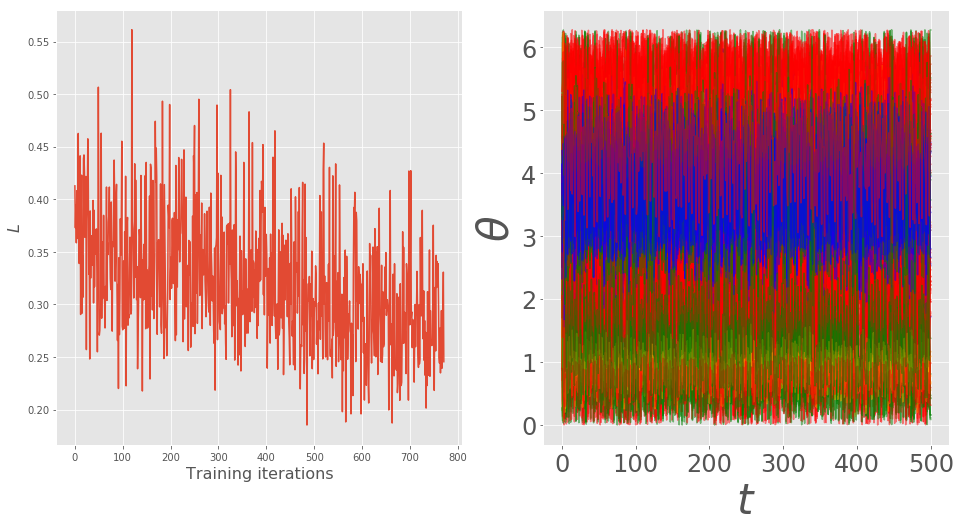

In [20]:
visualization_time=500
kn.set_grids(alpha, visualization_time, 1)

# Get one test batch
for j, batch in enumerate(zip(*[test_dls[key] for key in data_keys])):
    X = {key : x.float().to(device) for (key, (x,_)) in zip(data_keys, batch)}
    Y = {key : y for (key, (_,y)) in zip(data_keys, batch)}
    masks = make_masks(Y,num_classes,device)
    target = batch[0][1].numpy()
    break
# Run
with torch.no_grad():
    kn.eval()
    flow = kn.run(X, full_trajectory=True)
print('Optimized loss: %.04f' % loss_func(flow[burn_in_steps:], masks=masks))
flow = flow.data.cpu().numpy() 
flow %= 2*np.pi

# Plot
fig, axes = plt.subplots(1,2,figsize=(16,8))
all_colors = ['red', 'green', 'blue', 'orange', 'yellow', 'purple', 'pink', 'gray', 'black', 'magenta']
flow_colors = [all_colors[tg] for tg in target]

axes[0].plot(loss_train)
axes[0].set_xlabel('Training iterations', fontsize=16)
axes[0].set_ylabel(r'$L$', fontsize=16)
axes[1].set_prop_cycle('color', flow_colors)
axes[1].plot(flow, alpha=.5)
axes[1].set_xlabel(r'$t$',fontsize=42)
axes[1].set_ylabel(r'$\theta$',fontsize=42)
plt.xticks(fontsize=24)
plt.yticks(fontsize=24)

plt.show()
plt.close()

## Animation

Now, we'll plot the dynamics 

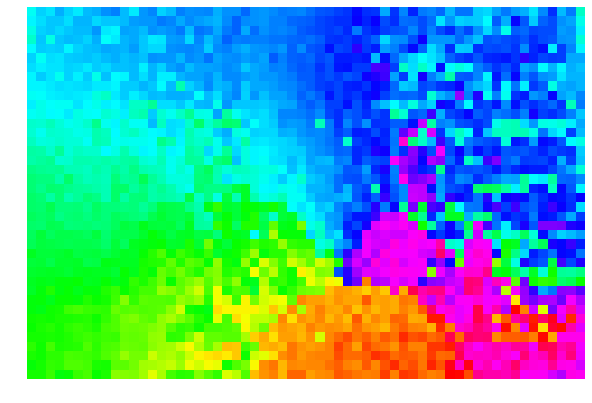

In [17]:
# Load original image
img = imread(os.path.join(full_BSDS_path, 'images/{}/{}.jpg'.format('val', dist_names[0])))
h, w, _ = img.shape
subsample = 8
resized = cv.resize(img, (int(w/subsample), int(h/subsample)), interpolation=cv.INTER_NEAREST)
h, w, _ = resized.shape
xx = np.repeat(np.linspace(0,w,w)[None,:], h, axis=0)[:,:,None] / w
yy = np.repeat(np.linspace(0,h,h)[:,None], w, axis=1)[:,:,None] / h
X = np.concatenate([resized / 255, xx, yy], axis=-1).reshape(-1, 5)

X = {data_names[0]:torch.tensor(X).float().to(device)}

kn.set_batch_size(100)
kn.rand_inds=True
kn.set_grids(alpha, 15000, 1)

with torch.no_grad():
    kn.eval()
    flow = kn.run(X, full_trajectory=True)
last_flow = flow[-1]
last_flow = last_flow.cpu().numpy()
last_flow = np.squeeze((last_flow % ((2*np.pi) + 2*np.pi)) % (2*np.pi)).reshape(h, w)
fig, ax = plt.subplots(figsize=(10,10))
plt.imshow(last_flow, cmap='hsv')
plt.gca().axis('off')
plt.show()
# plt.savefig(os.path.join(fig_dir, f'phase_{i_split}.png'))
plt.close()


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
from matplotlib.animation import FuncAnimation
from IPython.display import HTML
rc('animation', html='html5')

fig, axes = plt.subplots(1,2,figsize=(8,4))
flow_x         = np.cos(flow)
flow_x_control = np.cos(flow_control)
flow_y         = np.sin(flow)
flow_y_control = np.sin(flow_control)

frames = flow.shape[0]

def update(i):
    for ax, sc, ln, fl, fl_cmp in zip(axes, [scatter0,scatter1],[line0, line1], [flow, flow_control], [[flow_x, flow_y], [flow_x_control, flow_y_control]]):
        angle = fl[i,...].mean()
        state = np.concatenate((fl_cmp[0][i,...].reshape(-1,1), fl_cmp[1][i,...].reshape(-1,1)),axis=-1)
        cv = circular_variance(torch.tensor(fl[i,...])).numpy()
        sc.set_offsets(state)
        ln.set_data([0, (1-cv)*np.cos(angle)],[0, (1-cv)*np.sin(angle)])
    return scatter0,scatter1,line0,line1,


for ax, cl, fl, fl_cmp in zip(axes, ['r','b'],[flow, flow_control], [[flow_x, flow_y], [flow_x_control, flow_y_control]]):
    ax.set_xlim(( -1.25, 1.25))
    ax.set_ylim((-1.25, 1.25))
    scatter = ax.scatter(fl_cmp[0][0,...], fl_cmp[1][0,...], color=cl, alpha=.15)
    angle = fl[0,...].mean()
    state = np.concatenate((fl_cmp[0][0,...].reshape(-1,1), fl_cmp[1][0,...].reshape(-1,1)),axis=-1)
    cv = circular_variance(torch.tensor(fl[0,...])).numpy()
    line, = ax.plot([0, (1-cv)*np.cos(angle)],[0, (1-cv)*np.sin(angle)], color = cl, linewidth = 1)
    lines.append(line)
    scatters.append(scatter)

scatter0 = scatters[0]
scatter1 = scatters[1]
line0 = lines[0]
line1 = lines[1]

anim = FuncAnimation(fig, update, frames=frames, blit=True, interval=20)
html = HTML(anim.to_html5_video())
display(html)
plt.close() # update
# Save
# anim.save(os.path.join(home, 'kuramoto.mp4'), writer='ffmpeg', fps=45)
